# Retail Data Analytics
---

アメリカにおける小売店販売データを用いて、時系列予測を行います。<br>
引用元https://www.kaggle.com/manjeetsingh/retaildataset

以下の手順で行っていきます。<br>

1. 設定と目標
2. データの読み込み・EDA
3. データクレンジング
4. 前処理
5. 検証フローの作成
6. データの分割
7. モデリング
8. 予測・検証結果の分析

## 1. 設定と目標

あるStoreのあるDepartmentにおける最新の1週間の売り上げを予測することを目標とします。<br>
正確な予測結果は、無駄な発注や在庫ロスの削減等に繋がります。<br>
各Departmentの売り上げ予測から、全体の売り上げを予測し、見通しを立てることで戦略的決定を行い収益向上を目指します。<br>

## 2. データの読み込み・EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

sns.set_style("darkgrid")

In [2]:
retail = pd.read_csv("../raw_data/retail_data.csv",parse_dates=["Date"])

In [3]:
retail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-05-10,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-12-10,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


In [4]:
retail.shape

(421570, 16)

In [5]:
retail["Date"].describe()

C:\Users\Takeshi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  421570
unique                    143
top       2011-12-23 00:00:00
freq                     3027
first     2010-01-10 00:00:00
last      2012-12-10 00:00:00
Name: Date, dtype: object

In [6]:
retail.describe(include="all")

C:\Users\Takeshi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-23 00:00:00,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3027,NaN,391909,215478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2010-01-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2012-12-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,NaN,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,NaN,22711.183519,NaN,NaN,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,NaN,-4988.940000,NaN,NaN,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2079.650000,NaN,NaN,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000


<function matplotlib.pyplot.show(*args, **kw)>

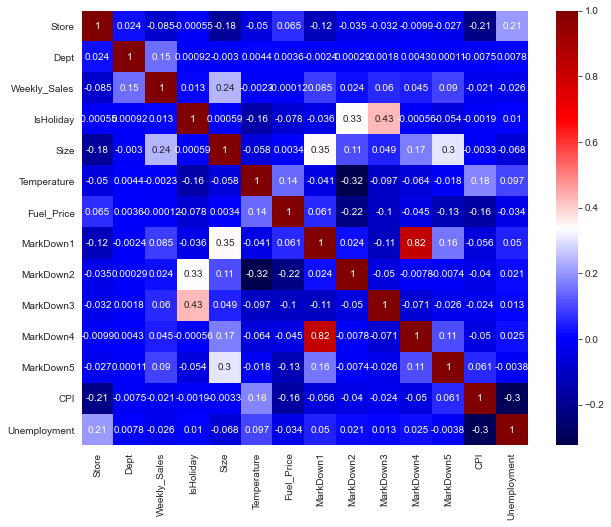

In [7]:
#相関係数を見る
corr = retail.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, cmap="seismic")
plt.show

In [8]:
#各店舗のデータ数をカウントする
count = retail.groupby(["Store", "Dept"]).count()
count

Date  Weekly_Sales  IsHoliday  Type  Size  Temperature  \
Store Dept                                                           
1     1      143           143        143   143   143          143   
      2      143           143        143   143   143          143   
      3      143           143        143   143   143          143   
      4      143           143        143   143   143          143   
      5      143           143        143   143   143          143   
...          ...           ...        ...   ...   ...          ...   
45    94     134           134        134   134   134          134   
      95     143           143        143   143   143          143   
      96       2             2          2     2     2            2   
      97     143           143        143   143   143          143   
      98     135           135        135   135   135          135   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Store Dept                                                                      
1     1            143         51         42         50         51         51   
      2            143         51         42         50         51         51   
      3            143         51         42         50         51         51   
      4            143         51         42         50         51         51   
      5            143         51         42         50         51         51   
...                ...        ...        ...        ...        ...        ...   
45    94           134         51         42         49         51         51   
      95           143         51         42         49         51         51   
      96             2          2          1          2          2          2   
      97           143         51         42         49         51         51   
      98           135         51         42         49         51         51   

            CPI  Unemployment  
Store Dept                     
1     1     143           143  
      2     143           143  
      3     143           143  
      4     143           143  
      5     143           143  
...         ...           ...  
45    94    134           134  
      95    143           143  
      96      2             2  
      97    143           143  
      98    135           135  

[3331 rows x 14 columns]

In [9]:
#週の売上の最大データ数
print(count["Weekly_Sales"].max())

#週の売上のデータ数が最大かどうか
print(count["Weekly_Sales"] == count["Weekly_Sales"].max())

#最大のものはどれだけあるのか
print((count["Weekly_Sales"] == count["Weekly_Sales"].max()).sum())

#割合
print((count["Weekly_Sales"] == count["Weekly_Sales"].max()).sum()/len(count))

143
Store  Dept
1      1        True
       2        True
       3        True
       4        True
       5        True
               ...  
45     94      False
       95       True
       96      False
       97       True
       98      False
Name: Weekly_Sales, Length: 3331, dtype: bool
2660
0.7985589912939057


## 3. データクレンジング

In [10]:
grouped_size = count["Weekly_Sales"]
grouped_size

Store  Dept
1      1       143
       2       143
       3       143
       4       143
       5       143
              ... 
45     94      134
       95      143
       96        2
       97      143
       98      135
Name: Weekly_Sales, Length: 3331, dtype: int64

In [11]:
#データが不完全なものは1つずつ取り除く
del_data = grouped_size[grouped_size != grouped_size.max()].index.values

drop_ids = []
for id_ in del_data:
    store_id = id_[0]
    dept_id = id_[1]
    
    #Storeとdeptが特定の組み合わせのindexをリストへ格納していく
    drop_ids.extend(retail[(retail["Store"] == store_id) & (retail["Dept"] == dept_id)].index.values)

#不要なindexをdropする
retail = retail.drop(drop_ids)

In [12]:
retail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421430,45,97,2012-09-28,6269.73,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421431,45,97,2012-05-10,6573.18,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421432,45,97,2012-12-10,6463.32,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421433,45,97,2012-10-19,5575.90,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


In [13]:
#確認
count = retail.groupby(["Store","Dept"]).count()
count["Weekly_Sales"].describe()

count    2660.0
mean      143.0
std         0.0
min       143.0
25%       143.0
50%       143.0
75%       143.0
max       143.0
Name: Weekly_Sales, dtype: float64

In [14]:
#Weekly_Salesが不の値を取る行を確認
retail[retail["Weekly_Sales"]<=0].sort_values(by="Weekly_Sales").head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
267730,28,6,2010-08-10,-4988.94,False,A,206302,71.82,3.013,NaN,NaN,NaN,NaN,NaN,126.279167,14.313
271300,28,32,2011-03-25,-1321.48,False,A,206302,54.40,3.909,NaN,NaN,NaN,NaN,NaN,128.616064,14.021
24830,3,32,2011-09-30,-1008.96,False,B,37392,82.58,3.355,NaN,NaN,NaN,NaN,NaN,220.085696,7.567
332894,35,16,2012-08-24,-771.90,False,B,103681,72.93,3.834,5726.77,NaN,57.08,5332.71,4133.91,142.310593,8.839
332898,35,16,2012-09-21,-244.17,False,B,103681,66.10,4.038,6982.10,87.37,6.00,2085.94,9129.21,142.679817,8.839


In [15]:
#負のデータの行を変数に格納
neg_data = retail[retail["Weekly_Sales"]<=0]

#負のデータのStoreとdeptを取得してその組み合わせのデータをdropする　※zip関数で複数のリストを同時にループ
for store_id, dept_id in zip(neg_data["Store"].values, neg_data["Dept"].values):
    drop_ids = retail[(retail["Store"]==store_id) & (retail["Dept"]==dept_id)].index
    retail = retail.drop(drop_ids)

In [16]:
#残った店舗数を確認
count = retail.groupby(["Store", "Dept"]).count()
count

Date  Weekly_Sales  IsHoliday  Type  Size  Temperature  \
Store Dept                                                           
1     1      143           143        143   143   143          143   
      2      143           143        143   143   143          143   
      3      143           143        143   143   143          143   
      4      143           143        143   143   143          143   
      5      143           143        143   143   143          143   
...          ...           ...        ...   ...   ...          ...   
45    91     143           143        143   143   143          143   
      92     143           143        143   143   143          143   
      93     143           143        143   143   143          143   
      95     143           143        143   143   143          143   
      97     143           143        143   143   143          143   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Store Dept                                                                      
1     1            143         51         42         50         51         51   
      2            143         51         42         50         51         51   
      3            143         51         42         50         51         51   
      4            143         51         42         50         51         51   
      5            143         51         42         50         51         51   
...                ...        ...        ...        ...        ...        ...   
45    91           143         51         42         49         51         51   
      92           143         51         42         49         51         51   
      93           143         51         42         49         51         51   
      95           143         51         42         49         51         51   
      97           143         51         42         49         51         51   

            CPI  Unemployment  
Store Dept                     
1     1     143           143  
      2     143           143  
      3     143           143  
      4     143           143  
      5     143           143  
...         ...           ...  
45    91    143           143  
      92    143           143  
      93    143           143  
      95    143           143  
      97    143           143  

[2627 rows x 14 columns]

店舗数を3331から2627まで減らすことに成功

In [17]:
#加工データを書き出し
retail.to_csv('../processed_data/cleaned_retail.csv',index=False)

## 4. 前処理

In [18]:
cleaned_retail = pd.read_csv('../processed_data/cleaned_retail.csv',parse_dates=['Date'])
cleaned_retail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [19]:
#Date列をindexにし、Date列を削除しindexで並び替え
cleaned_retail = cleaned_retail.sort_values(by=["Store","Dept","Date"])
cleaned_retail.index = cleaned_retail["Date"]
del cleaned_retail["Date"]
cleaned_retail = cleaned_retail.sort_index()

In [20]:
cleaned_retail

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-01-10,1,1,20094.19,False,A,151315,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838
2010-01-10,37,4,16554.25,False,C,39910,74.66,2.603,NaN,NaN,NaN,NaN,NaN,210.440443,8.476
2010-01-10,8,12,5390.93,False,A,155078,68.70,2.603,NaN,NaN,NaN,NaN,NaN,215.031003,6.433
2010-01-10,17,82,14561.26,False,B,93188,60.07,2.853,NaN,NaN,NaN,NaN,NaN,126.234600,6.885
2010-01-10,45,33,4165.97,False,B,118221,70.58,2.707,NaN,NaN,NaN,NaN,NaN,182.716838,8.724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-10,1,20,3126.49,False,A,151315,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573
2012-12-10,6,23,31893.42,False,A,202505,65.43,3.601,1905.34,NaN,13.83,559.50,8706.87,225.005473,5.329
2012-12-10,39,40,70043.32,False,A,184109,69.88,3.601,2360.14,NaN,22.59,579.21,15387.94,222.051079,6.228


<function matplotlib.pyplot.show(*args, **kw)>

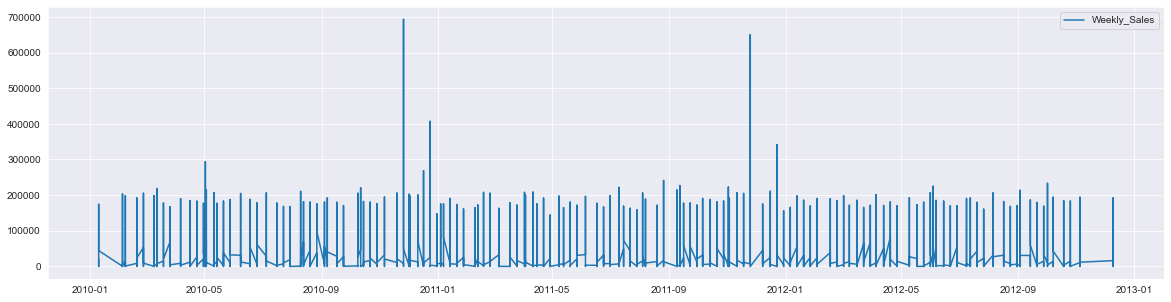

In [21]:
plt.figure(figsize=(20,5))
plt.plot(cleaned_retail["Weekly_Sales"])
plt.legend(["Weekly_Sales"])
plt.show

ある特定の時期に売上が伸びているが、データの周期性はあまり見られない為、lightgbmのアルゴリズムを使用する。

In [22]:
def lgb_preprocessing(df):
    """
    LightGBMモデルの単変量予測のための特徴量作成を行う関数です
    
    """
    
    #元のデータが変わってしまうためコピーする
    full = df.copy()
    
    # Stringのカラムをダミー変数化　※Ａ⇒0 B⇒1 C⇒2へ変換
    STRING_COLUMNS = {
        "Type": {"A":0, "B":1, "C":2}
    }
    for str_col, replace_dict in STRING_COLUMNS.items():
        full[str_col].replace(replace_dict, inplace=True)
        
    #Dateの情報を含める
    full['year'] = full.index.year
    full['month'] = full.index.month
    full['day'] = full.index.day
    
    # store-deptごとに特徴量作成
    grouped = full.groupby(["Store", "Dept"])
    full_new = pd.DataFrame()
    
    for label, df_one in tqdm(grouped):
        
        # 先に知ることができない情報は1つずらす
        AVOID_COLUMNS = ['Weekly_Sales', 'Store', 'Dept', 'IsHoliday', 'Type', 'Size']
        df_one[df_one.columns[~df_one.columns.isin(AVOID_COLUMNS)]] = \
            df_one.drop(AVOID_COLUMNS,axis=1).shift()
        
        #ラグ（差分）を取る　lag1～5の列を追加し、Weekly_Salesを一つずつずらした値を格納する
        n = 5
        for i in range(1,n):
            df_one['lag'+str(i)] = df_one['Weekly_Sales'].shift(i)

        #移動平均と標準偏差を算出し、1つずらして列を挿入
        rolling_n = [4]
        for i in rolling_n:
            df_one['Weekly_Sales_rolling_mean_' + str(i)] = df_one['Weekly_Sales'].rolling(i).mean().shift()
            df_one['Weekly_Sales_rolling_std_' + str(i)] = df_one['Weekly_Sales'].rolling(i).std().shift()

        #前日差を取り、1つずらして列を挿入
        df_one['shuekiritu'] = df_one['Weekly_Sales'].diff().shift()
        
        # 結合
        full_new = pd.concat([full_new, df_one], sort=False)
    
    full_new = full_new.reset_index()
    
    #列の型をlightgbm用に変える
    for col in ['Store','Dept','IsHoliday','Type']:
        df[col] = df[col].astype('category')
    for col in ['Size']:
        df[col] = df[col].astype(float)
    
    return full_new

In [23]:
# lgb_preprocessingの処理結果確認

import warnings
warnings.simplefilter("ignore")

pp_retail = lgb_preprocessing(cleaned_retail)

  0%|          | 0/2627 [00:00<?, ?it/s]

In [24]:
pp_retail.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,year,month,day,lag1,lag2,lag3,lag4,Weekly_Sales_rolling_mean_4,Weekly_Sales_rolling_std_4,shuekiritu
0,2010-01-10,1,1,20094.19,False,0,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-04,1,1,57258.43,False,0,151315,71.89,2.603,NaN,...,2010.0,1.0,10.0,20094.19,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-07,1,1,16333.14,False,0,151315,62.27,2.719,NaN,...,2010.0,2.0,4.0,57258.43,20094.19,NaN,NaN,NaN,NaN,37164.24
3,2010-02-19,1,1,41595.55,False,0,151315,80.91,2.669,NaN,...,2010.0,2.0,7.0,16333.14,57258.43,20094.19,NaN,NaN,NaN,-40925.29
4,2010-02-26,1,1,19403.54,False,0,151315,39.93,2.514,NaN,...,2010.0,2.0,19.0,41595.55,16333.14,57258.43,20094.19,33820.3275,19183.389612,25262.41


In [25]:
pp_retail["Date"][0]

Timestamp('2010-01-10 00:00:00')

## 5. 検証フローの作成

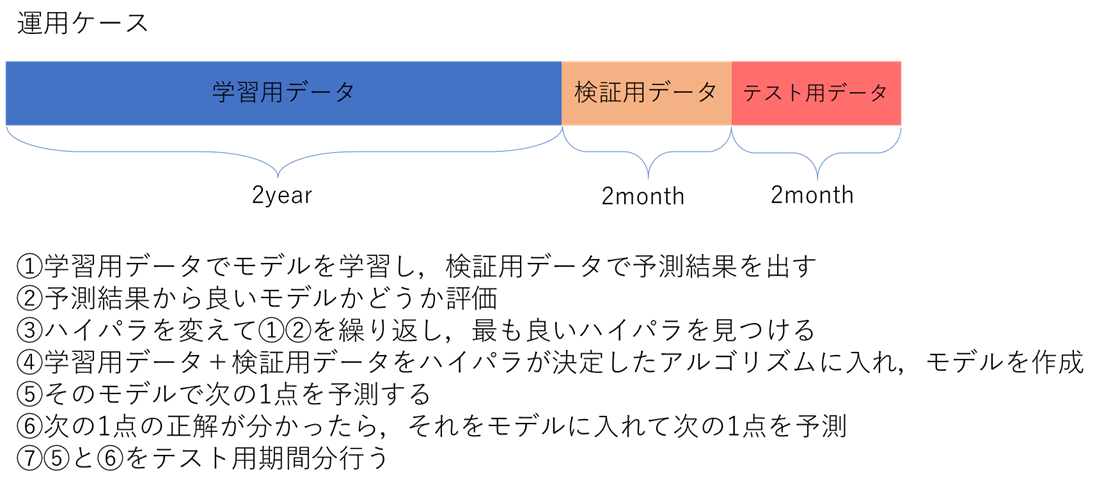

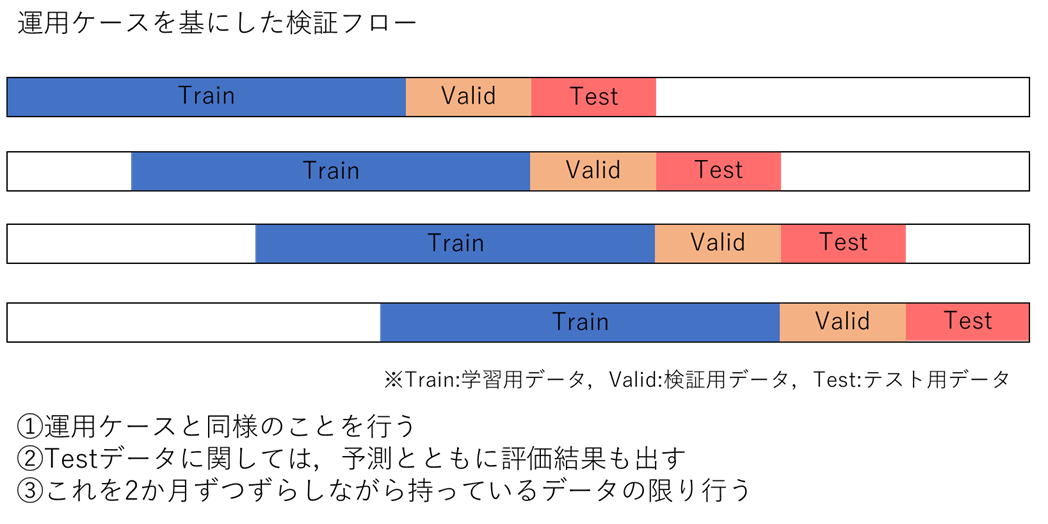

## 6. データの分割
時系列データを2年を学習用、次の2か月を検証用、その次の2か月をテスト用に分割します。

In [26]:
def time_series_split(df,train_start):
    
    """
    時系列と時間を与えると、学習データ2年分、検証用データ2か月分、テスト用データ2か月分に分ける

    Parameters:
    ----------
    df : データフレーム、データシリーズ

    train_start : 学習期間の最も最初の日付
    
    Returns
    -------
    train : 学習用データ
    valid : 検証用データ
    test : テスト用データ
    test_end : 最後の日付

    """
    
    #使う変数を宣言
    year2 = datetime.timedelta(days=365*2)
    month2 = datetime.timedelta(days=60)

    #学習用データを作る
    train_end = train_start+year2
    train = df[(train_start <= df["Date"]) & (df["Date"] < train_end)]

    #検証用データを作る
    valid_start = train_end
    valid_end = valid_start + month2
    valid = df[(valid_start <= df["Date"]) & (df["Date"] < valid_end)]

    #テスト用データを作る
    test_start = valid_end
    test_end = test_start + month2
    test = df[(test_start <= df["Date"]) & (df["Date"] < test_end)]
    
    return train,valid,test,test_end

In [27]:
#実行
train,valid,test,test_end = time_series_split(pp_retail, train_start = pp_retail["Date"][0])

In [28]:
train["Date"]

0        2010-01-10
1        2010-02-04
2        2010-02-07
3        2010-02-19
4        2010-02-26
            ...    
375614   2011-12-08
375615   2011-12-16
375616   2011-12-23
375617   2011-12-30
375618   2012-01-06
Name: Date, Length: 265327, dtype: datetime64[ns]

In [29]:
train

,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,year,month,day,lag1,lag2,lag3,lag4,Weekly_Sales_rolling_mean_4,Weekly_Sales_rolling_std_4,shuekiritu
0,2010-01-10,1,1,20094.19,False,0,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-04,1,1,57258.43,False,0,151315,71.89,2.603,NaN,...,2010.0,1.0,10.0,20094.19,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-07,1,1,16333.14,False,0,151315,62.27,2.719,NaN,...,2010.0,2.0,4.0,57258.43,20094.19,NaN,NaN,NaN,NaN,37164.24
3,2010-02-19,1,1,41595.55,False,0,151315,80.91,2.669,NaN,...,2010.0,2.0,7.0,16333.14,57258.43,20094.19,NaN,NaN,NaN,-40925.29
4,2010-02-26,1,1,19403.54,False,0,151315,39.93,2.514,NaN,...,2010.0,2.0,19.0,41595.55,16333.14,57258.43,20094.19,33820.3275,19183.389612,25262.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375614,2011-12-08,45,97,6318.66,False,1,118221,48.71,3.492,140.87,...,2011.0,11.0,25.0,5200.55,6018.90,5795.63,7061.49,6019.1425,776.002553,-818.35
375615,2011-12-16,45,97,6330.62,False,1,118221,77.00,3.812,NaN,...,2011.0,12.0,8.0,6318.66,5200.55,6018.90,5795.63,5833.4350,473.220600,1118.11
375616,2011-12-23,45,97,6840.54,False,1,118221,39.93,3.413,4631.26,...,2011.0,12.0,16.0,6330.62,6318.66,5200.55,6018.90,5967.1825,531.044047,11.96
375617,2011-12-30,45,97,5569.82,True,1,118221,42.27,3.389,797.10,...,2011.0,12.0,23.0,6840.54,6330.62,6318.66,5200.55,6172.5925,692.177456,509.92


In [30]:
#欠損値の情報を確認
pd.concat([train.isnull().sum(), valid.isnull().sum(), test.isnull().sum()], axis=1)

,0,1,2
Date,0,0,0
Store,0,0,0
Dept,0,0,0
Weekly_Sales,0,0,0
IsHoliday,0,0,0
Type,0,0,0
Size,0,0,0
Temperature,2627,0,0
Fuel_Price,2627,0,0
MarkDown1,244530,0,114


## 7. モデリング

In [31]:
def make_lgb_dataset(df):
    
    """
    データフレームをLightGBM用のデータセットに変換します。
    
    Return:
    ------
    X : 説明変数のみのデータフレーム
    データセット : LightGBM用のデータセット
    
    """
    #対数変換
    df["log_Weekly_Sales"] = np.log1p(df["Weekly_Sales"])
    
    X = df.drop(['log_Weekly_Sales', "Weekly_Sales", "Date"],axis=1)
    y = df['log_Weekly_Sales']
    
    return X,lgb.Dataset(X,y)

In [32]:
def lgb_modelling_multi(train,valid,test):
    
    """
    LightGBMによる多変量時系列の予測を行います。
    
    Parameters:
    ------
    train,valid,test : time_series_split関数で得られるtrain,valid,testデータ
    
    Return:
    ------
    train_valid_predict:学習期間と検証期間の予測
    test_predict:テスト期間の予測
    best_bst :学習したモデル
    
    """
        
    #LGBMデータセットを作る
    X_train, lgb_train = make_lgb_dataset(train)
    X_valid, lgb_valid = make_lgb_dataset(valid)
    X_test, lgb_test = make_lgb_dataset(test)
    
    #ハイパーパラメーターチューニング
    lgb_params = {
            'objective': "regression",
            'metric':"rmse",
            'seed':2020
    }
    bst = lgb.train(
                lgb_params,
                train_set=lgb_train,
                valid_sets=lgb_valid,
                num_boost_round=1000,
                early_stopping_rounds=30,
                verbose_eval=False#途中経過を表示しない
            )
    
    #Trainとvalidを結合してデータセットを作る
    train_valid = pd.concat([train,valid])
    X_train_valid,lgb_train_valid = make_lgb_dataset(train_valid)

    #ハイパラが決まったら再度学習で予測
    best_bst = lgb.train(params=lgb_params,
                         train_set=lgb_train_valid,
                         num_boost_round=bst.best_iteration)

    #train_validの予測
    train_valid_predict = best_bst.predict(X_train_valid)
    train_valid_predict = np.expm1(train_valid_predict)
    train_valid_predict = pd.DataFrame(train_valid_predict,index=list(train.index)+list(valid.index),columns=['train_valid_predict'])
    train_valid_predict = pd.concat([train_valid,train_valid_predict],axis=1)[['Store','Dept','Date','Weekly_Sales','train_valid_predict']]
    
    #testの予測
    test_predict = best_bst.predict(X_test)
    test_predict = np.expm1(test_predict)
    test_predict = pd.DataFrame(test_predict,index=list(test.index),columns=['test_predict'])
    test_predict = pd.concat([test,test_predict],axis=1)[['Store','Dept','Date','Weekly_Sales','test_predict']]
    
    return train_valid_predict,test_predict,best_bst

In [33]:
train_valid_predict,test_predict,model = lgb_modelling_multi(train ,valid ,test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 265327, number of used features: 24
[LightGBM] [Info] Start training from score 8.967842
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 286343, number of used features: 24
[LightGBM] [Info] Start training from score 8.961095


In [34]:
train_valid_predict

,Store,Dept,Date,Weekly_Sales,train_valid_predict
0,1,1,2010-01-10,20094.19,29339.256639
1,1,1,2010-02-04,57258.43,38551.159823
2,1,1,2010-02-07,16333.14,17966.349745
3,1,1,2010-02-19,41595.55,23375.659669
4,1,1,2010-02-26,19403.54,25146.036246
...,...,...,...,...,...
375622,45,97,2012-02-03,6161.44,7204.735036
375623,45,97,2012-02-17,6216.86,7496.415304
375624,45,97,2012-02-24,5665.18,6595.732457
375625,45,97,2012-03-02,6253.66,6021.452139


In [35]:
test_predict

,Store,Dept,Date,Weekly_Sales,test_predict
109,1,1,2012-03-16,22366.88,20030.710125
110,1,1,2012-03-23,22107.70,18623.090661
111,1,1,2012-03-30,28952.86,18508.368617
112,1,1,2012-04-05,17147.44,18054.174992
113,1,1,2012-04-13,34684.21,20984.737361
...,...,...,...,...,...
375629,45,97,2012-03-30,5899.36,5926.470067
375630,45,97,2012-04-05,6881.80,7215.315077
375631,45,97,2012-04-13,6079.68,6168.750949
375632,45,97,2012-04-20,6748.28,5917.981820


In [36]:
model

## 8. 予測・検証結果の分析

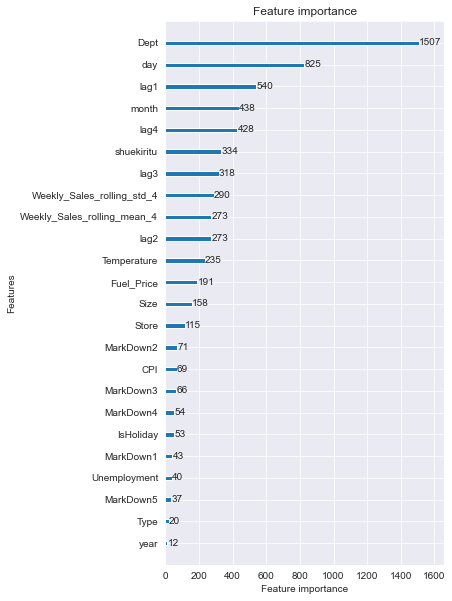

In [37]:
#feature_importance確認
lgb.plot_importance(model, importance_type="split", figsize=(5, 10))
plt.show()

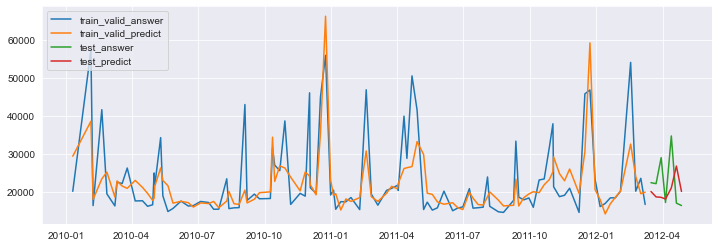

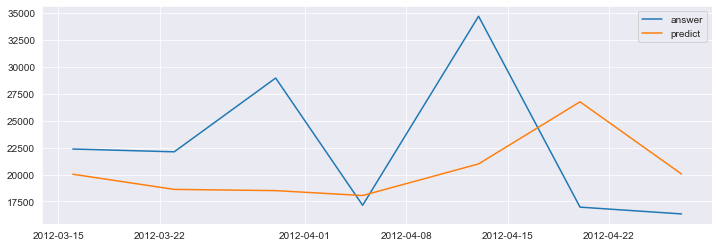

In [38]:
#IDがそれぞれ１の予測を取り出す
one_tv_predict = train_valid_predict[(train_valid_predict['Store']==1) & (train_valid_predict['Dept']==1)]
one_test_predict = test_predict[(test_predict['Store']==1) & (test_predict['Dept']==1)]

#train_validの予測と答え
plt.figure(figsize=(12,4))
plt.plot(one_tv_predict['Date'],one_tv_predict['Weekly_Sales'])
plt.plot(one_tv_predict['Date'],one_tv_predict['train_valid_predict'])
plt.plot(one_test_predict['Date'],one_test_predict['Weekly_Sales'])
plt.plot(one_test_predict['Date'],one_test_predict['test_predict'])
plt.legend(['train_valid_answer','train_valid_predict','test_answer','test_predict'])
plt.show()

#test期間の予測と答え
plt.figure(figsize=(12,4))
plt.plot(one_test_predict['Date'],one_test_predict['Weekly_Sales'])
plt.plot(one_test_predict['Date'],one_test_predict['test_predict'])
plt.legend(['answer','predict'])
plt.show()

In [39]:
#検証フローを繰り返し行う

#期間の初期設定
train_start = cleaned_retail.index[0]
test_end = train_start

#rollingごとの結果格納変数
models = []
test_predicts = pd.DataFrame([])

while test_end < cleaned_retail.index[-1]:
    
    #データ分割
    train,valid,test,test_end = time_series_split(pp_retail,train_start=train_start)

    #モデリング
    train_valid_predict,test_predict,model = lgb_modelling_multi(train ,valid ,test)

    #モデルと結果を順に格納
    models.append(model)
    test_predicts = pd.concat([test_predicts,test_predict])
    
    #2か月加算（これがないとwhile文が終わらない）
    train_start += datetime.timedelta(days=60)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 265327, number of used features: 24
[LightGBM] [Info] Start training from score 8.967842
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 286343, number of used features: 24
[LightGBM] [Info] Start training from score 8.961095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4267
[LightGBM] [Info] Number of data points in the train set: 270581, number of used features: 24
[LightGBM] [Inf

In [40]:
test_predicts

,Store,Dept,Date,Weekly_Sales,test_predict
109,1,1,2012-03-16,22366.88,20030.710125
110,1,1,2012-03-23,22107.70,18623.090661
111,1,1,2012-03-30,28952.86,18508.368617
112,1,1,2012-04-05,17147.44,18054.174992
113,1,1,2012-04-13,34684.21,20984.737361
...,...,...,...,...,...
375374,45,93,2012-12-10,2644.24,2629.659701
375516,45,95,2012-11-05,51925.15,55028.347714
375517,45,95,2012-12-10,49334.77,51160.699305
375659,45,97,2012-11-05,6584.52,6659.265448


In [41]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score

#評価指標の作成
def output_result(answer,predict,metric=None):
    """
    指定された文字列に合わせて評価指標を算出
    
    Parameters:
    -------
    answer : 正解
    predict : 予測
    metric : 評価指標（'MAE','MSE','MSLE','r2_score','RMSE','RMSLE','MAPE'から選択）
    
    Return:
    -------
    算出結果
    
    """
    if metric == 'MAE':
        return mean_absolute_error(answer,predict)
    elif metric == 'MSE':
        return mean_squared_error(answer,predict)
    elif metric == 'MSLE':
        return mean_squared_log_error(answer,predict)
    elif metric == 'r2_score':
        return r2_score(answer,predict)
    elif metric == 'RMSE':
        return np.sqrt(mean_squared_error(answer,predict))
    elif metric == 'RMSLE':
        return np.sqrt(mean_squared_log_error(answer,predict))
    elif metric == 'MAPE':
        return (abs(answer-predict)/answer).mean()

In [42]:
print(output_result(test_predicts['Weekly_Sales'],test_predicts['test_predict'],metric='RMSE'))

4669.162032125934


In [43]:
test_predicts['test_predict']

109       20030.710125
110       18623.090661
111       18508.368617
112       18054.174992
113       20984.737361
              ...     
375374     2629.659701
375516    55028.347714
375517    51160.699305
375659     6659.265448
375660     6197.876575
Name: test_predict, Length: 89318, dtype: float64

In [ ]:
#すべてのStoreとDeptの組み合わせについて、各指標の評価値を計算しでデータフレームへ格納

metrics = ['MAPE','RMSE','r2_score']
result = pd.DataFrame([],columns=['Store','Dept']+metrics)

size = test_predicts.groupby(["Store","Dept"]).size()

#1店舗取り出す
for store_id,dept_id in size.index.values:
    one_test_result = test_predicts[(test_predicts['Store']==store_id) & (test_predicts['Dept']==dept_id)]
    
    #各指標について評価値を計算、格納
    mets = []
    for metric in metrics:
        mets.append(output_result(one_test_result['Weekly_Sales'],one_test_result['test_predict'],metric=metric))

    #すべて出たらStoreとDeptのIDとともに表に加える
    one_result = pd.Series([store_id]+[dept_id]+mets,index=['Store','Dept']+metrics)
    result = result.append(one_result,ignore_index=True)

result

In [46]:
result["MAPE"].isnull().sum()

0

In [47]:
#最も決定係数の高いIDを探す
result.sort_values(by='r2_score').tail(1)

,Store,Dept,MAPE,RMSE,r2_score
1945,32.0,28.0,0.264336,161.729318,0.480947


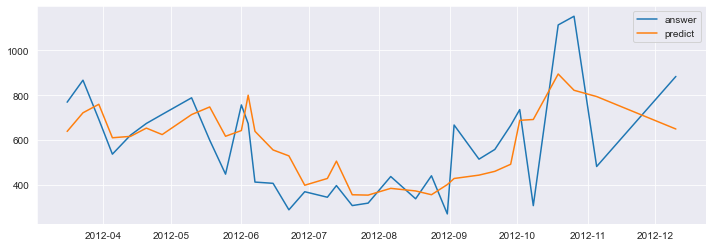

In [48]:
#最も決定係数の高い予測を可視化
one_test_result = test_predicts[(test_predicts['Store']==32) & (test_predicts['Dept']==28)]

plt.figure(figsize=(12,4))
plt.plot(one_test_result['Date'],one_test_result['Weekly_Sales'])
plt.plot(one_test_result['Date'],one_test_result['test_predict'])
plt.legend(['answer','predict'])
plt.show()

In [49]:
#最もMAPEの低いIDを探す
result.sort_values(by='MAPE').head(1)

,Store,Dept,MAPE,RMSE,r2_score
78,2.0,13.0,0.031022,1823.176502,-0.330385


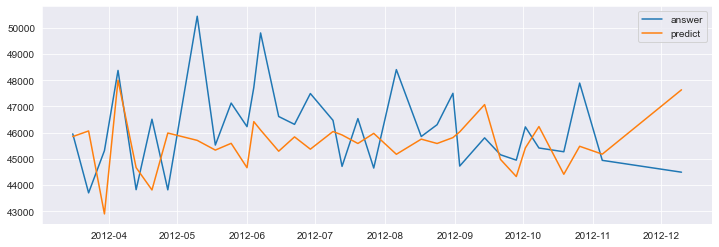

In [50]:
#最もMAPEの低いIDの予測を可視化
one_test_result = test_predicts[(test_predicts['Store']==2) & (test_predicts['Dept']==13)]

plt.figure(figsize=(12,4))
plt.plot(one_test_result['Date'],one_test_result['Weekly_Sales'])
plt.plot(one_test_result['Date'],one_test_result['test_predict'])
plt.legend(['answer','predict'])
plt.show()

In [51]:
#各指標の値の分布を見てみる
result.describe()

,Store,Dept,MAPE,RMSE,r2_score
count,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000
mean,21.894557,43.603350,0.199151,2867.577629,-0.220806
std,12.731000,30.932454,0.270291,3685.545178,0.361593
min,1.000000,1.000000,0.031022,14.400165,-9.824968
25%,11.000000,17.000000,0.087084,687.063948,-0.347086
50%,21.000000,35.000000,0.141259,1608.222177,-0.183096
75%,32.000000,74.000000,0.217519,3389.413821,-0.040206
max,45.000000,98.000000,4.509239,31736.176834,0.480947


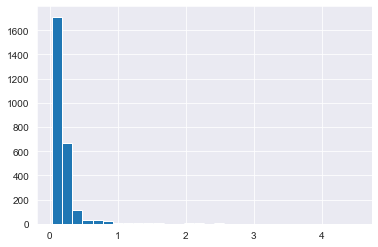

In [52]:
#MAPEの分布
plt.hist(result['MAPE'],bins=30)
plt.show()

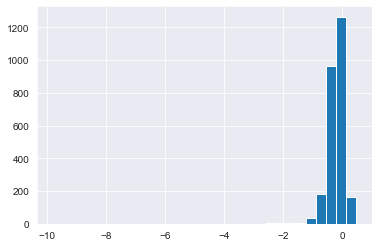

In [53]:
#決定係数の分布
plt.hist(result['r2_score'],bins=30)
plt.show()

In [54]:
#MAPEが0.1以下の店舗数
len(result[result['MAPE']<0.1])

836

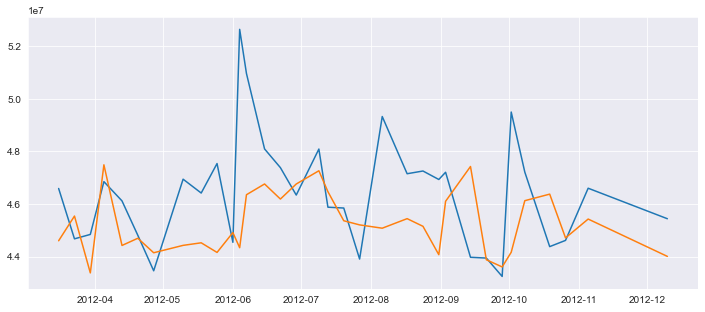

In [55]:
#全体の売上の予測
plt.figure(figsize=(12,5))
sum_sales = test_predicts.groupby(by='Date').sum()[['Weekly_Sales','test_predict']]
plt.plot(sum_sales['Weekly_Sales'])
plt.plot(sum_sales['test_predict'])
plt.show()

In [56]:
#全体の売上の予測精度（MAPE）
output_result(sum_sales['Weekly_Sales'],sum_sales['test_predict'],metric='MAPE')

0.03802546120675526

MAPEが0.1以下の店舗数が836店舗となり、該当する店舗に関する売上予測が出来ていると判断します。<br>
全体の予測に関しては、MAPEが0.03の結果で予測の精度が高く、次の予測も高い精度で当てられるものと思います。<br>